# fMTN behav feature vs slow-integrate-fast-adapt MA PC

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from scipy.ndimage import gaussian_filter1d as smooth
from sklearn import decomposition
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg
from disp import set_plot, set_color
from my_torch import skl_fit_ridge
from my_stats import nanpearsonr

from record_0_main import smlt_ma

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

PTRAIN = .8
NSPLIT = 30

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

ALPHA = 10

In [2]:
LOAD_DIR = f'data/simple/mlv/ma_vary_pc'
FPFX = 'ma_slow_int_fast_adapt_save_y_npc'

In [3]:
fnames = [fname for fname in os.listdir(LOAD_DIR) if fname.startswith(FPFX)]

In [4]:
npcs = [int(fname[len(FPFX)+1:-4]) for fname in fnames]

fnames = np.array(fnames)[np.argsort(npcs)]
npcs = sorted(npcs)

r2_test_mns = {targ: [] for targ in TARGS}
r2_test_sds = {targ: [] for targ in TARGS}
r2_test_maxs = {targ: [] for targ in TARGS}

ws = {targ: [] for targ in TARGS}
y_tests = {targ: [] for targ in TARGS}
y_hat_tests = {targ: [] for targ in TARGS}

pcs = []

for fname in fnames:
    
    data = np.load(os.path.join(LOAD_DIR, fname), allow_pickle=True)[0]
    r2_trains = data['R2_TRAINS']
    r2_tests = data['R2_TESTS']
    
    for targ in TARGS:
        r2_test_mns[targ].append(np.mean(r2_tests[targ]))
        r2_test_sds[targ].append(np.std(r2_tests[targ]))
        r2_test_maxs[targ].append(np.max(r2_tests[targ]))
        
        try:
            ws[targ].append(data['WS'][targ])
        except:
            pass
        
        try:
            y_tests[targ].append(data['y_tests'][targ])
            y_hat_tests[targ].append(data['y_hat_tests'][targ])
        except:
            pass
        
    try:
        pcs.append(data['PCS'])
    except:
        pass

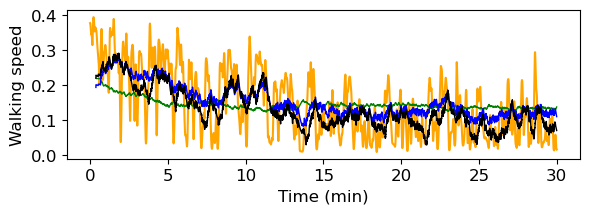

In [21]:
ISPLIT = 0
ITR = 3
TARG = TARGS[1]

NPCS = [1, 3, 10]
COLORS = ['g', 'b', 'k']

fig, ax = plt.subplots(1, 1, figsize=(6, 2.25), tight_layout=True)

for cnpc, npc in enumerate(NPCS):
    inpc = int(npc - 1)
    if npc == NPCS[0]:
        y_test = y_tests[TARG][inpc][0][ISPLIT][ITR]
        t = np.arange(len(y_test))*DT/60
        ax.plot(t, smooth(y_test, 50), c='orange')

    
    y_hat_test_npcs = []
    for cppln in range(len(y_tests[TARG][inpc])):
        try:
            y_hat_test = y_hat_tests[TARG][inpc][cppln][ISPLIT][ITR]
            y_hat_test_npcs.append(y_hat_test)
        except:
            continue
    ax.plot(t, np.mean(y_hat_test_npcs, 0), c=COLORS[cnpc], lw=1)
    
set_plot(ax, x_label='Time (min)', y_label='Walking speed')

fig.savefig(f'ms/fig_2_fmtn_pcs_split_{ISPLIT}_trial_{ITR}.svg')

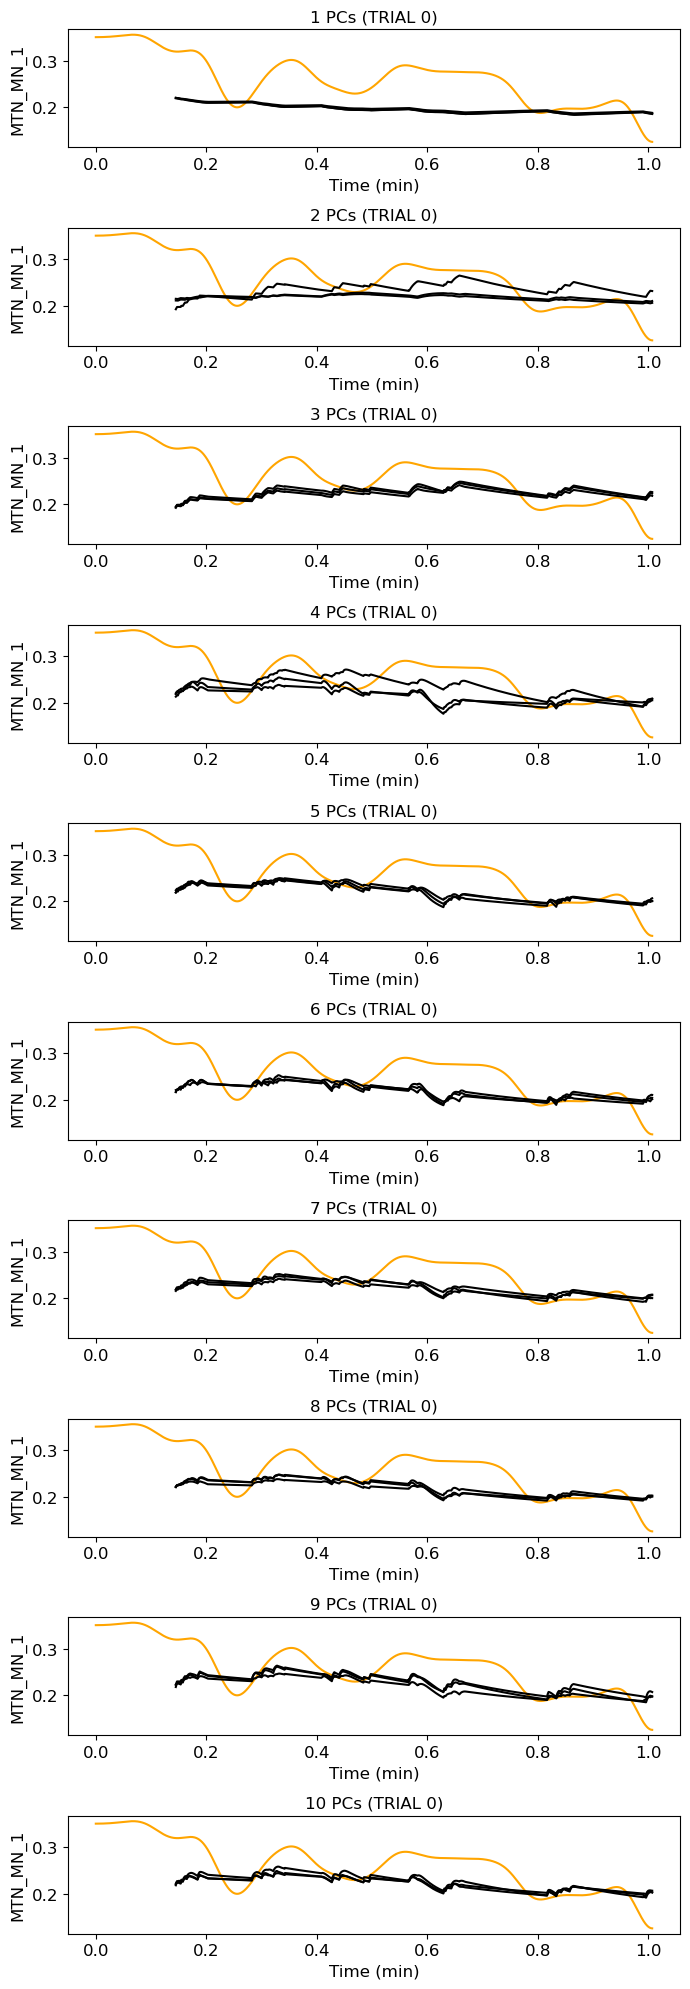

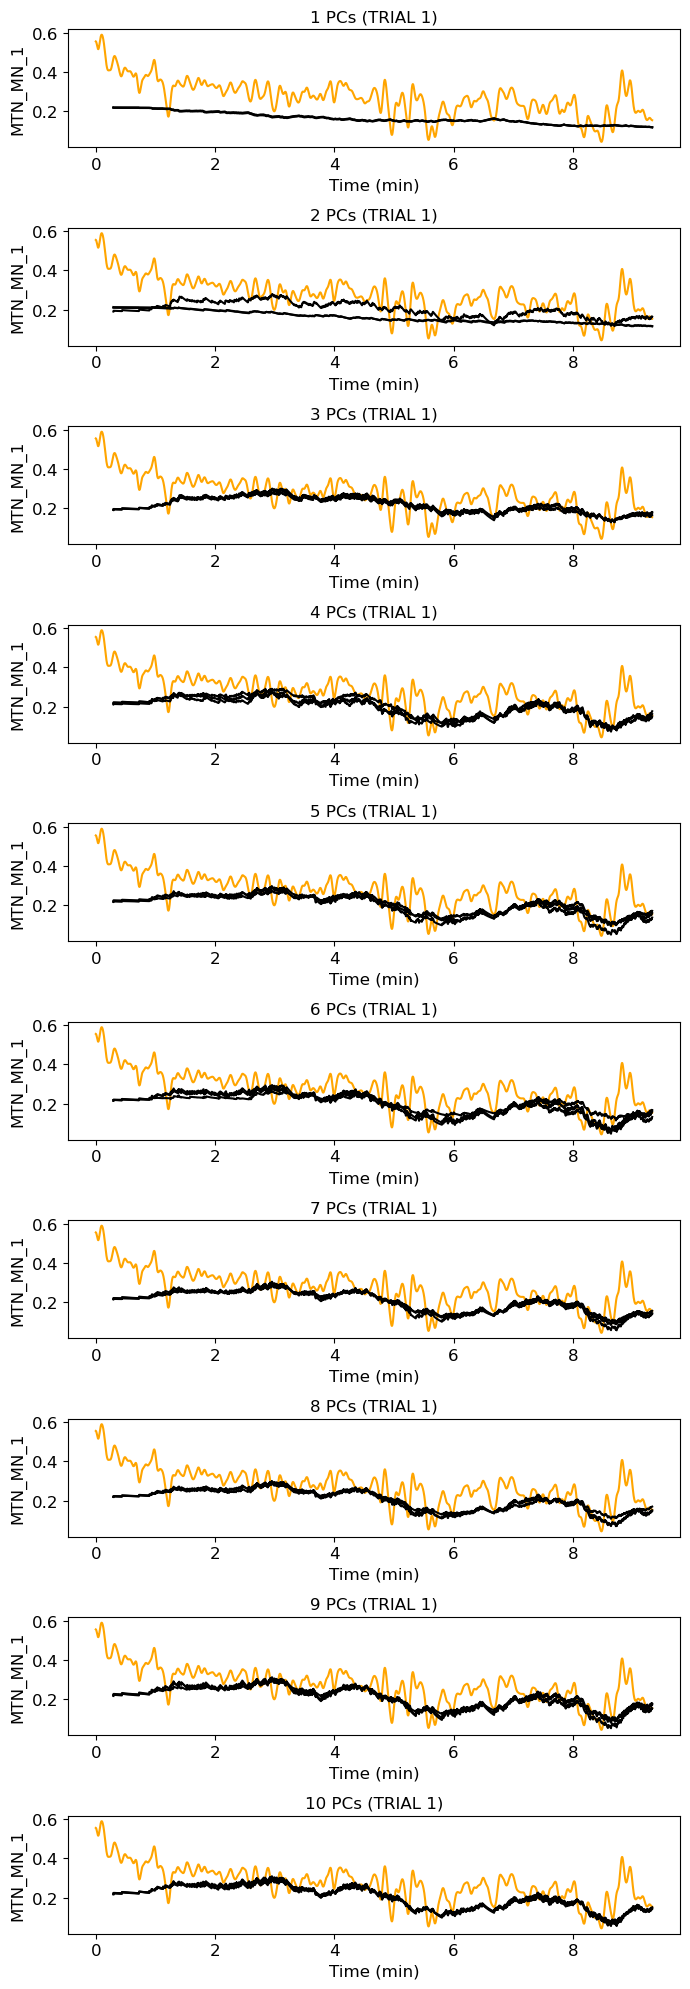

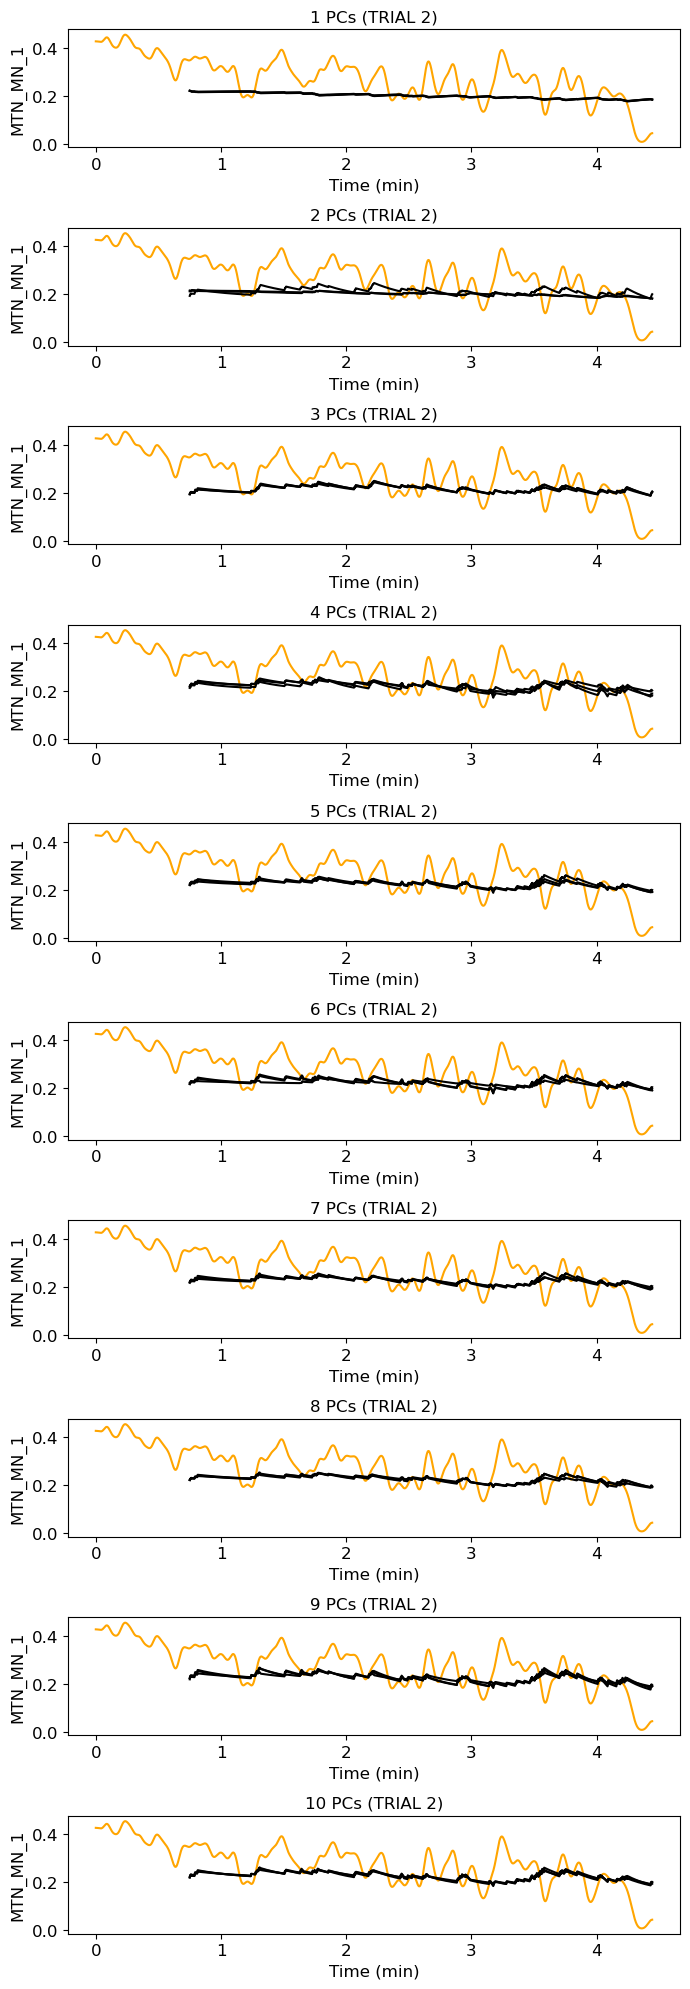

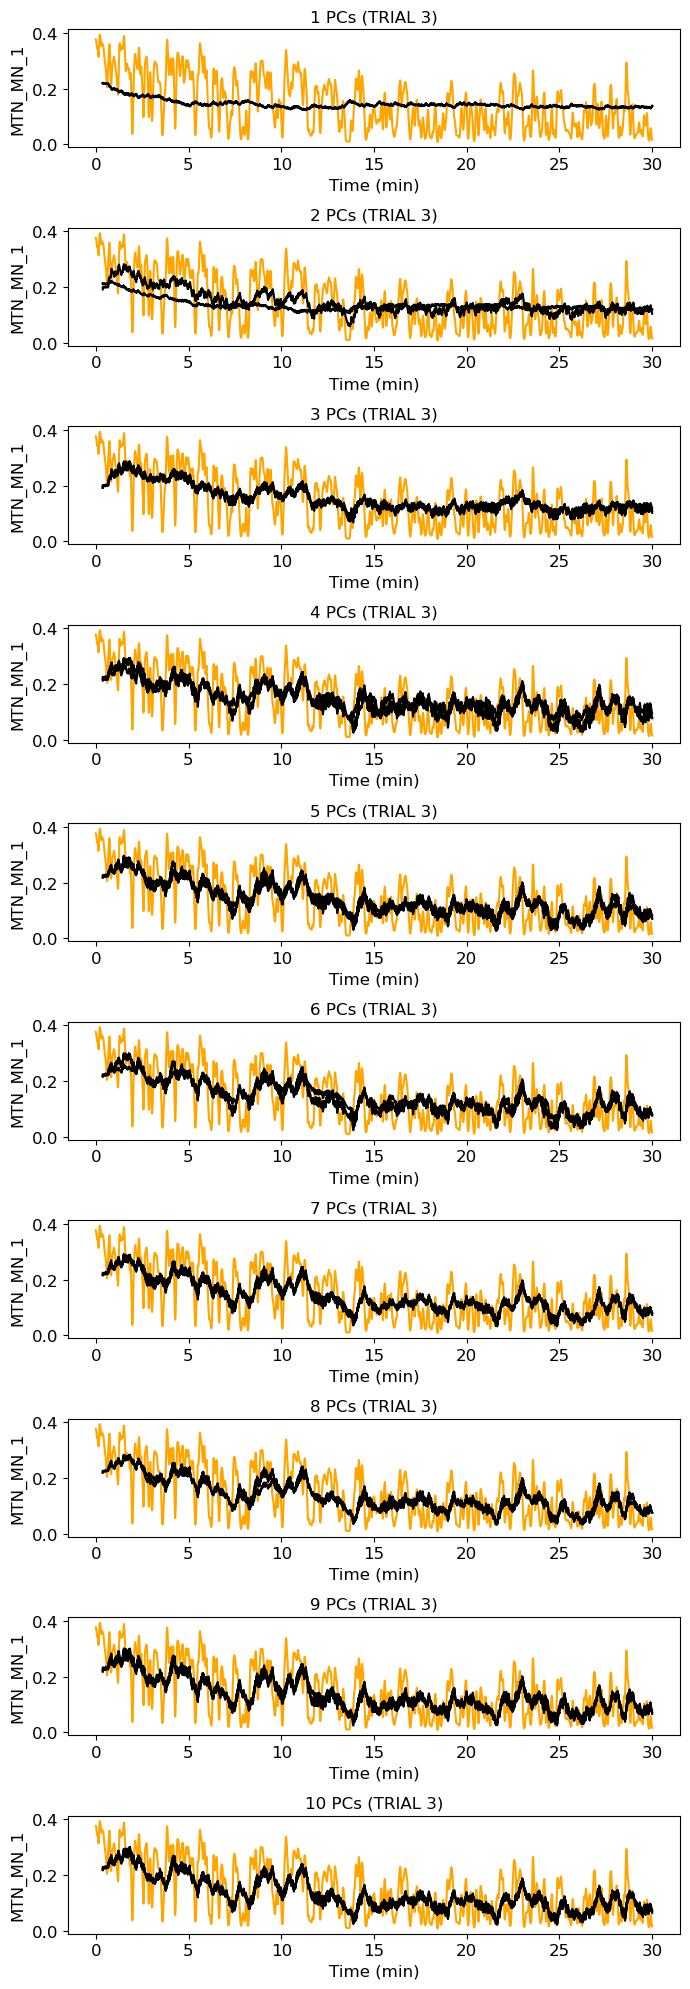

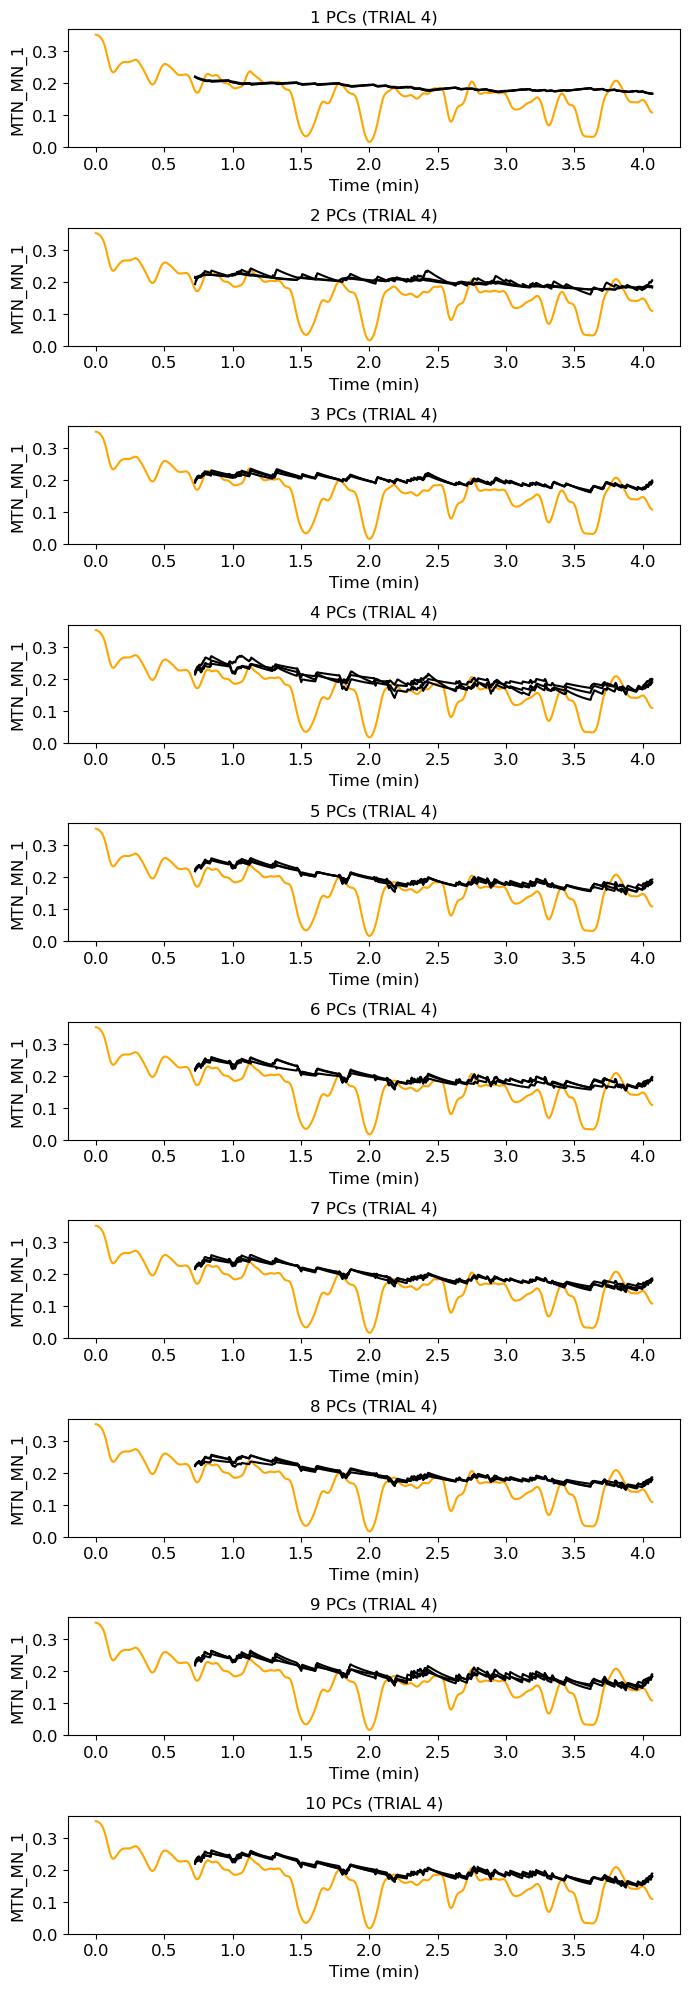

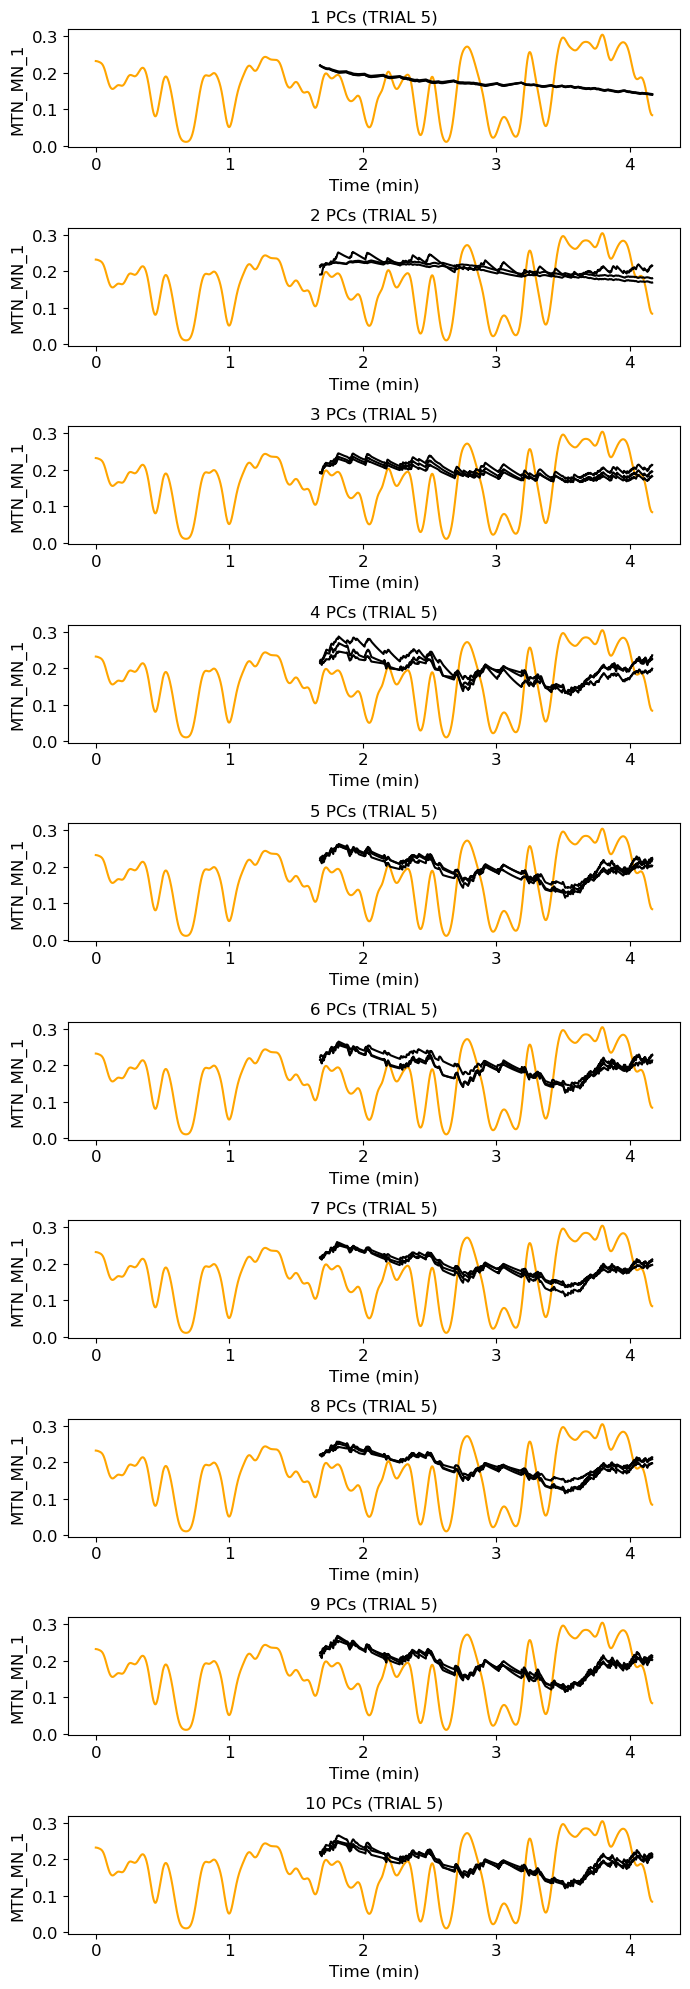

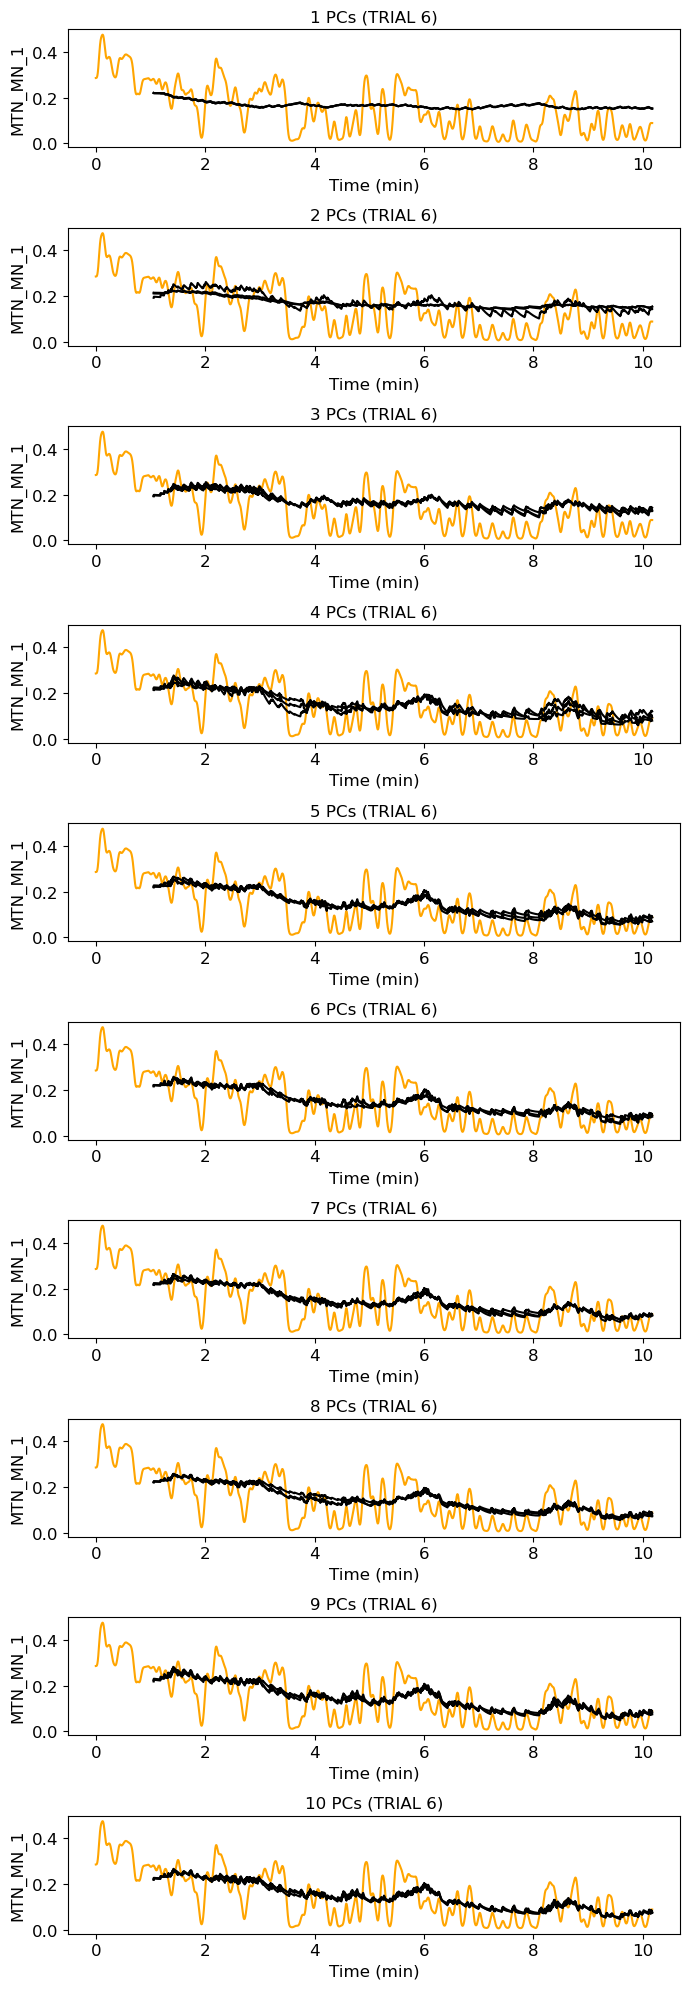

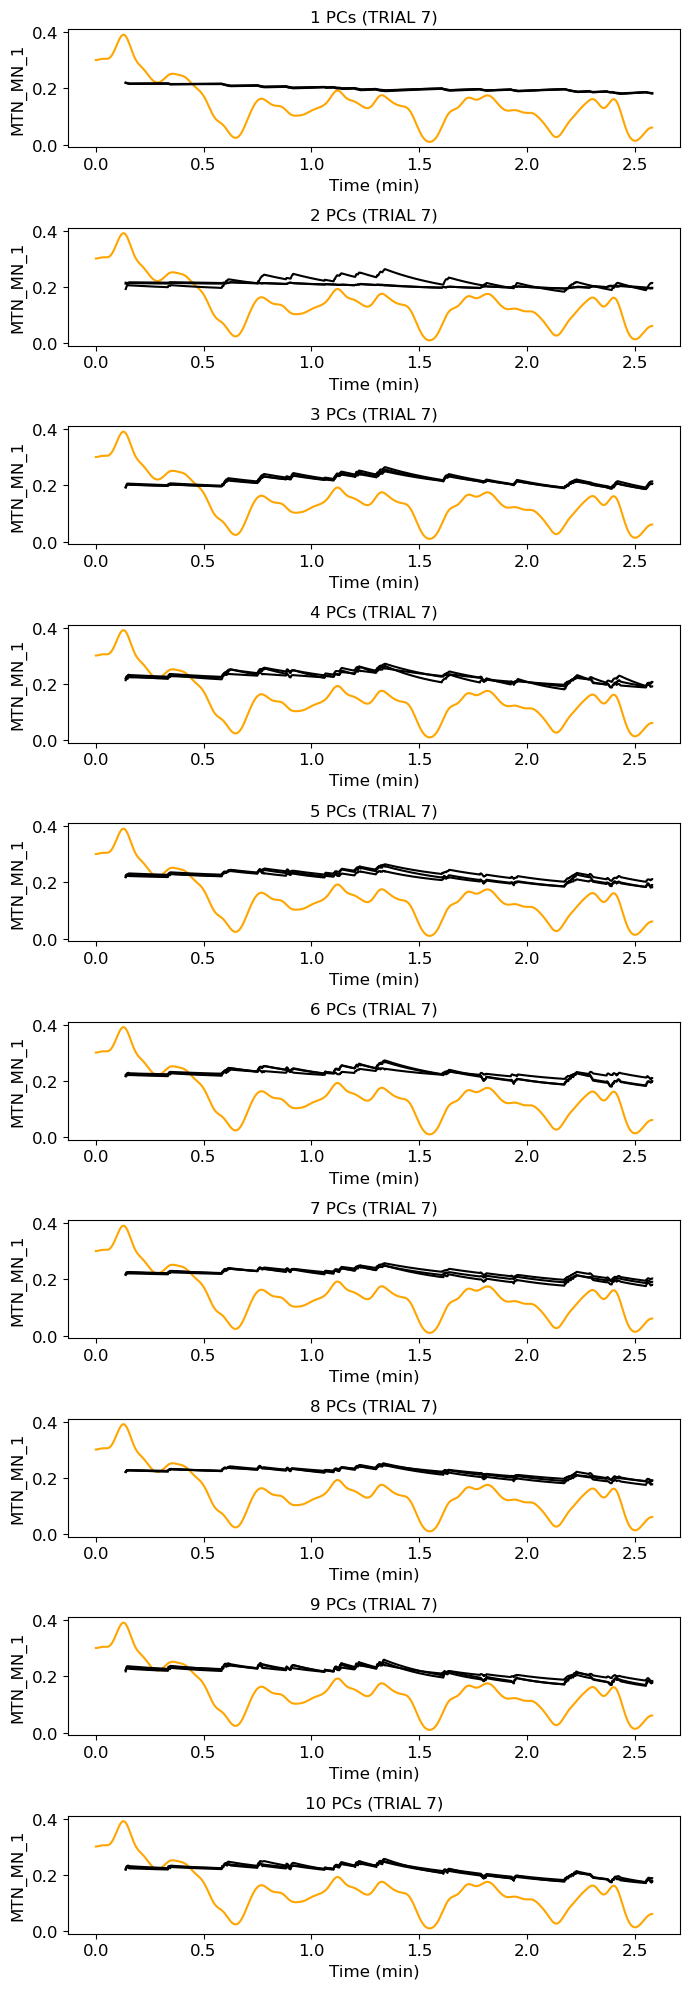

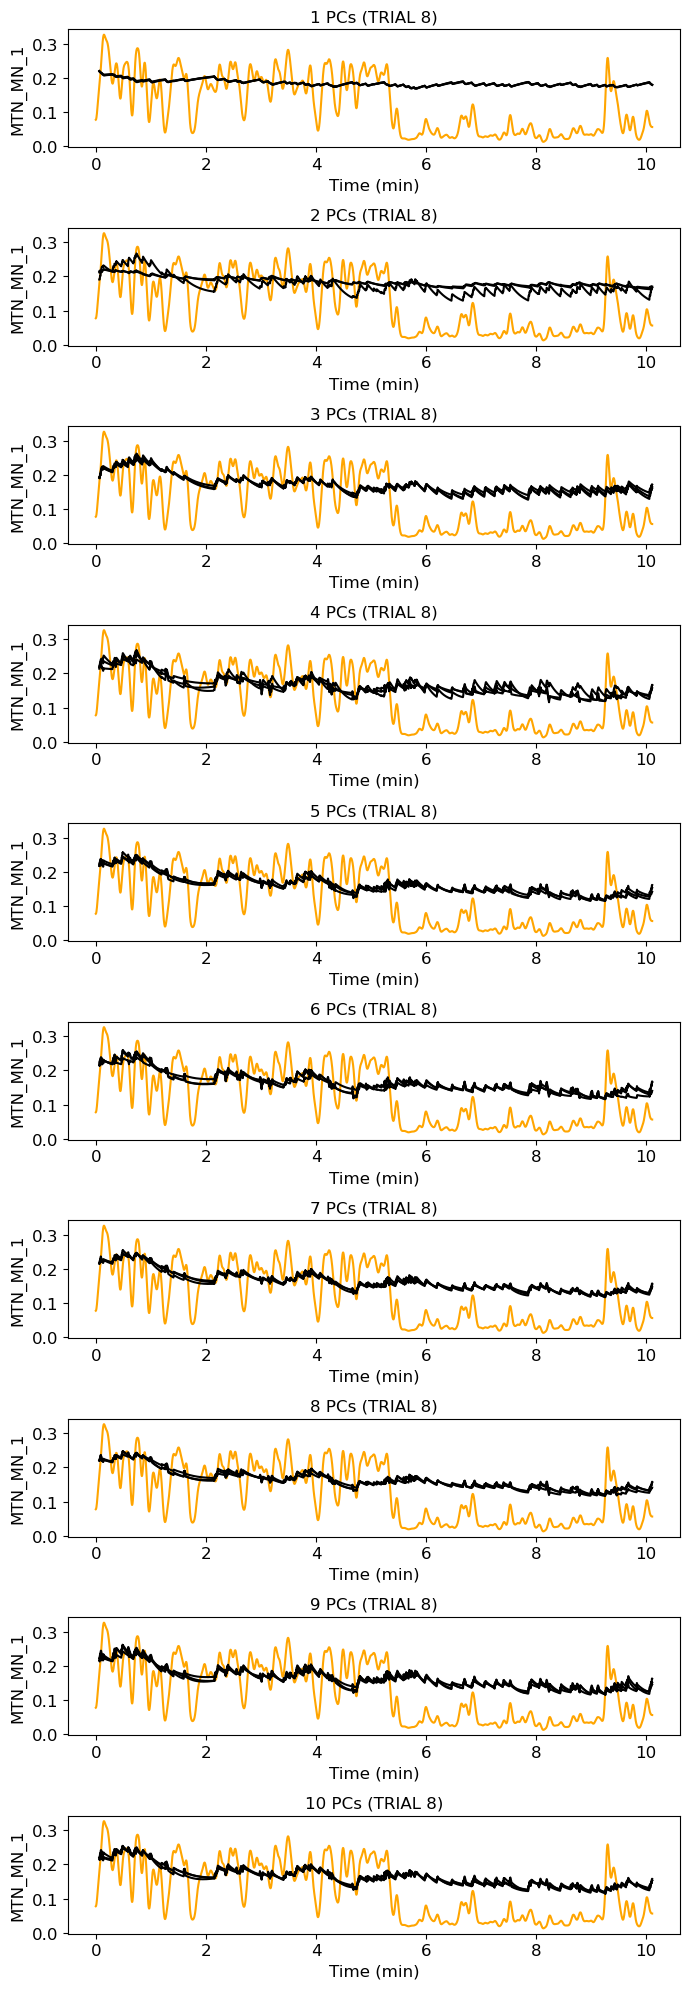

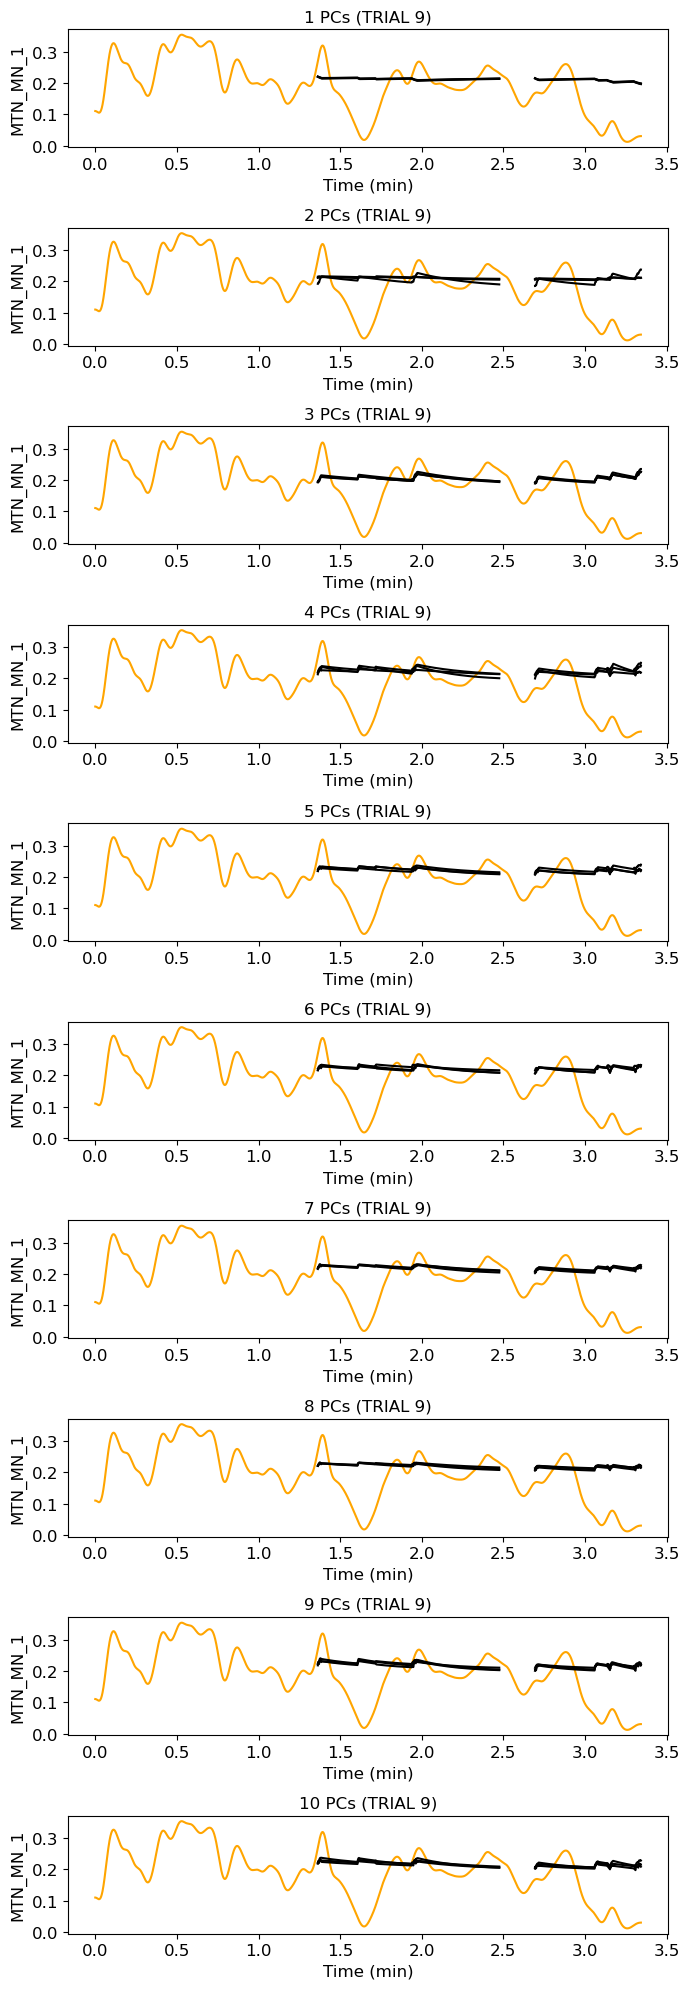

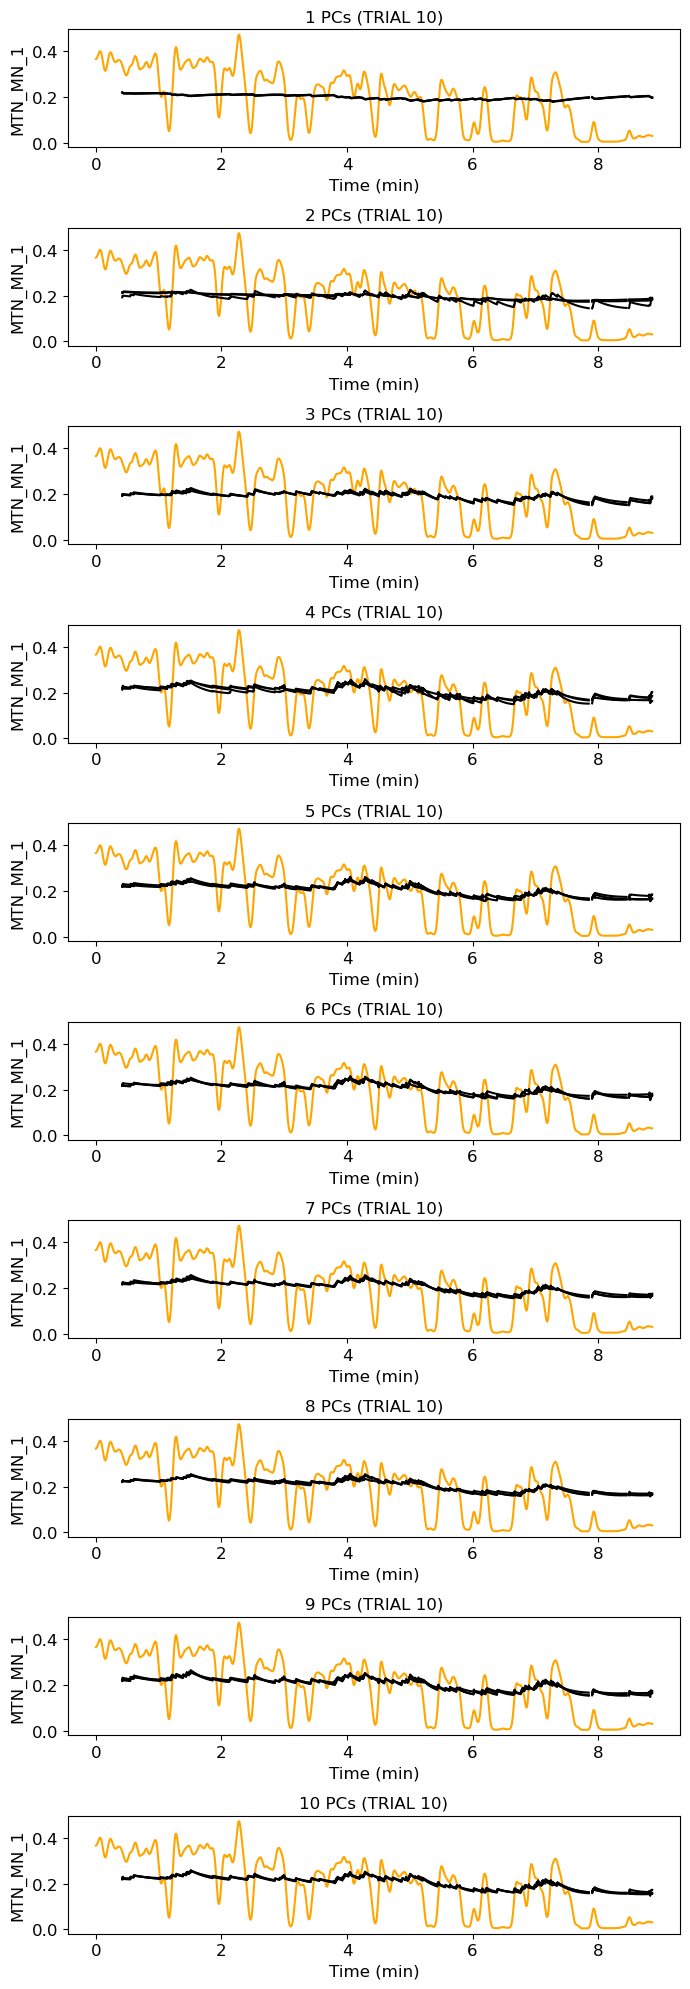

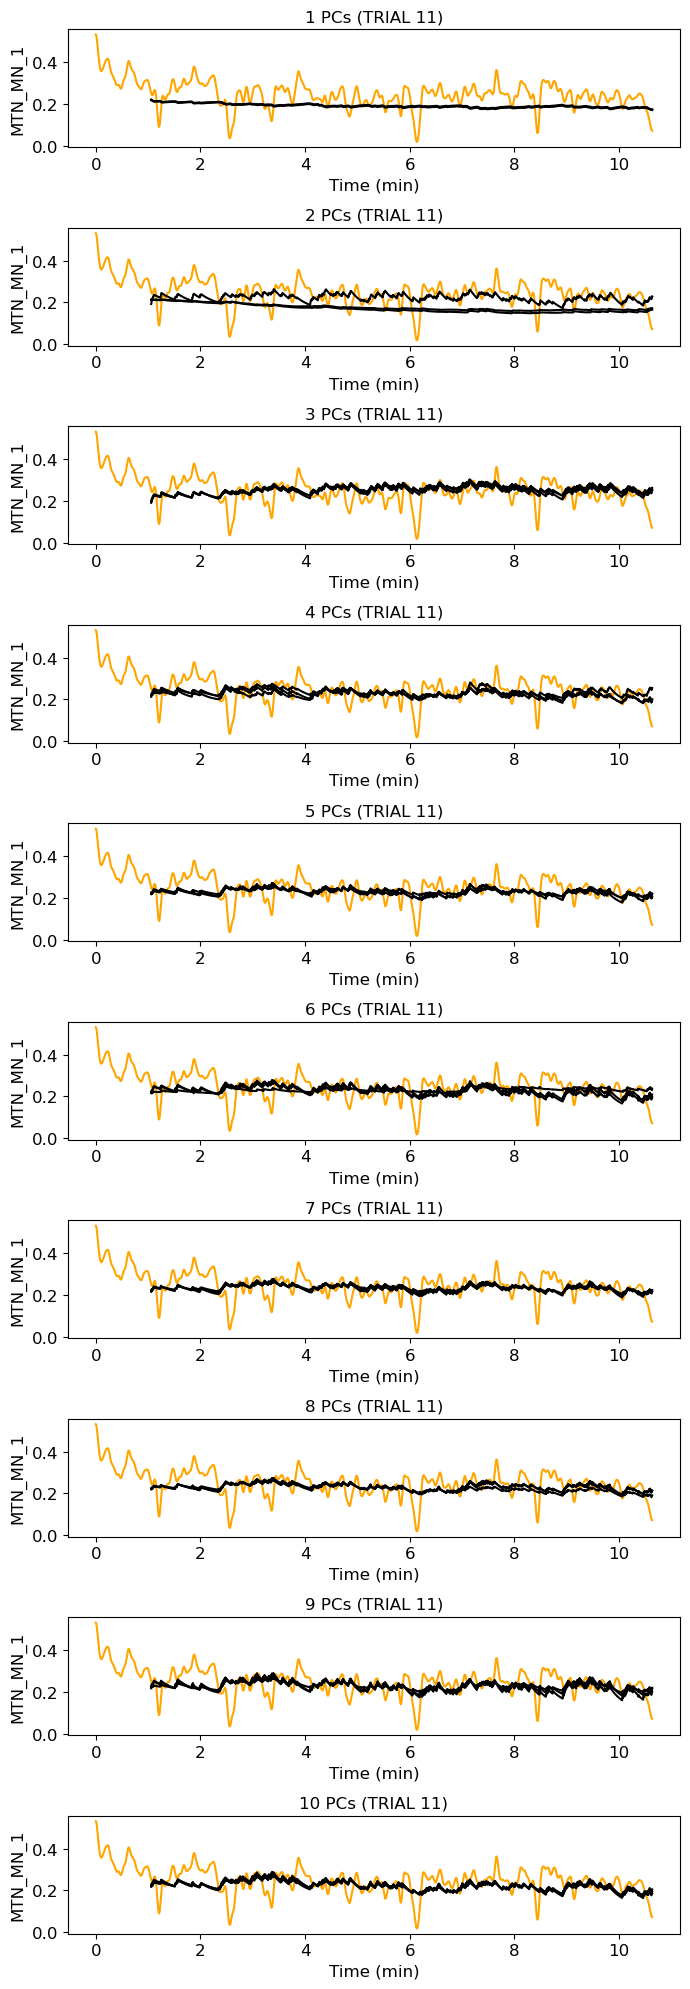

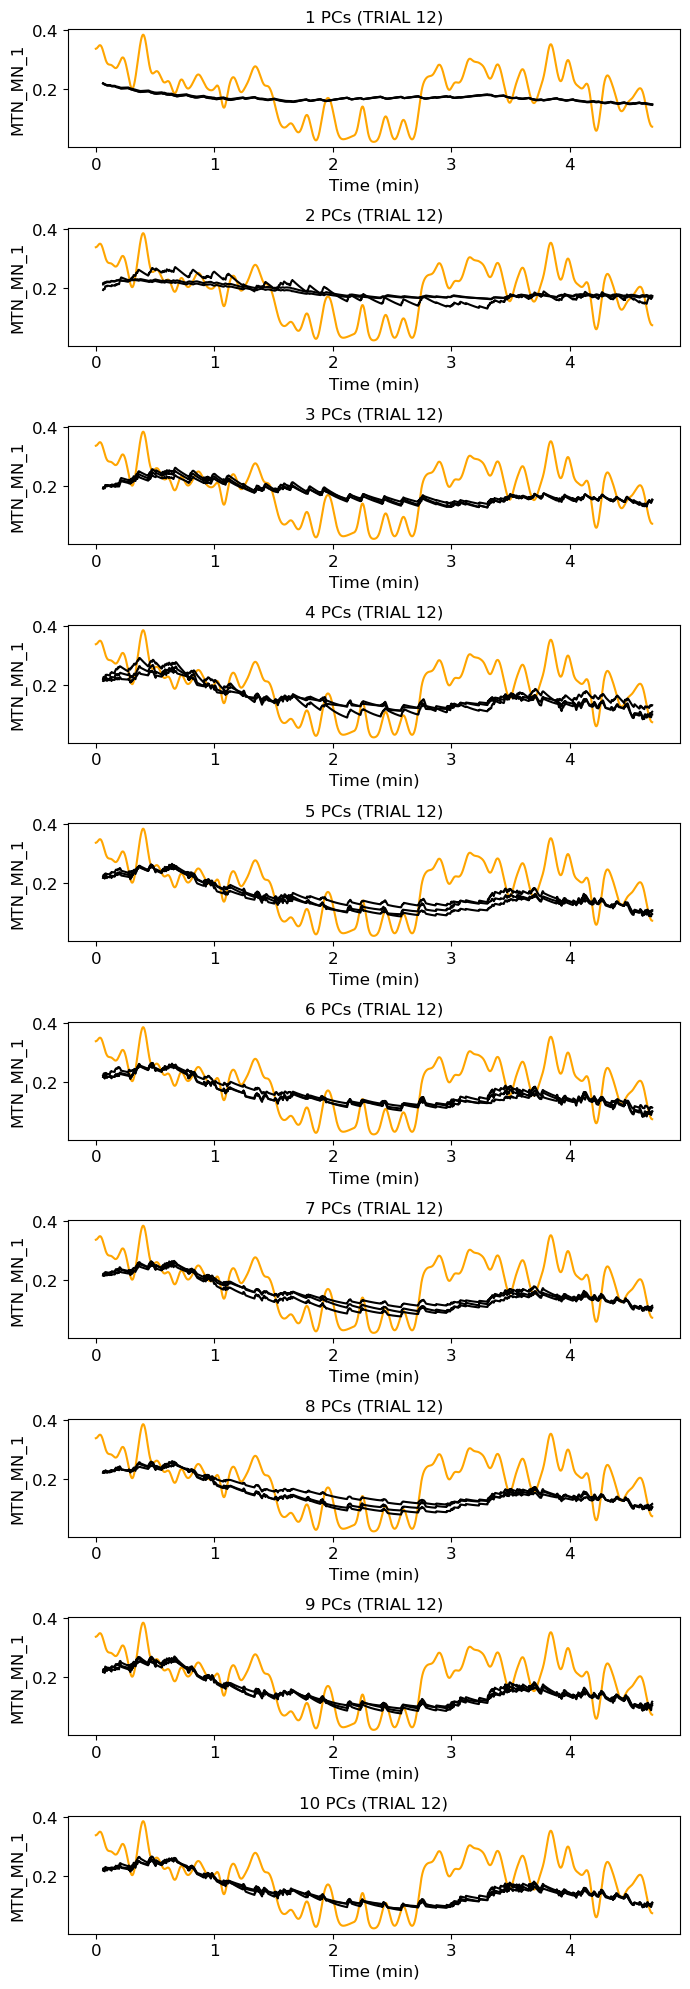

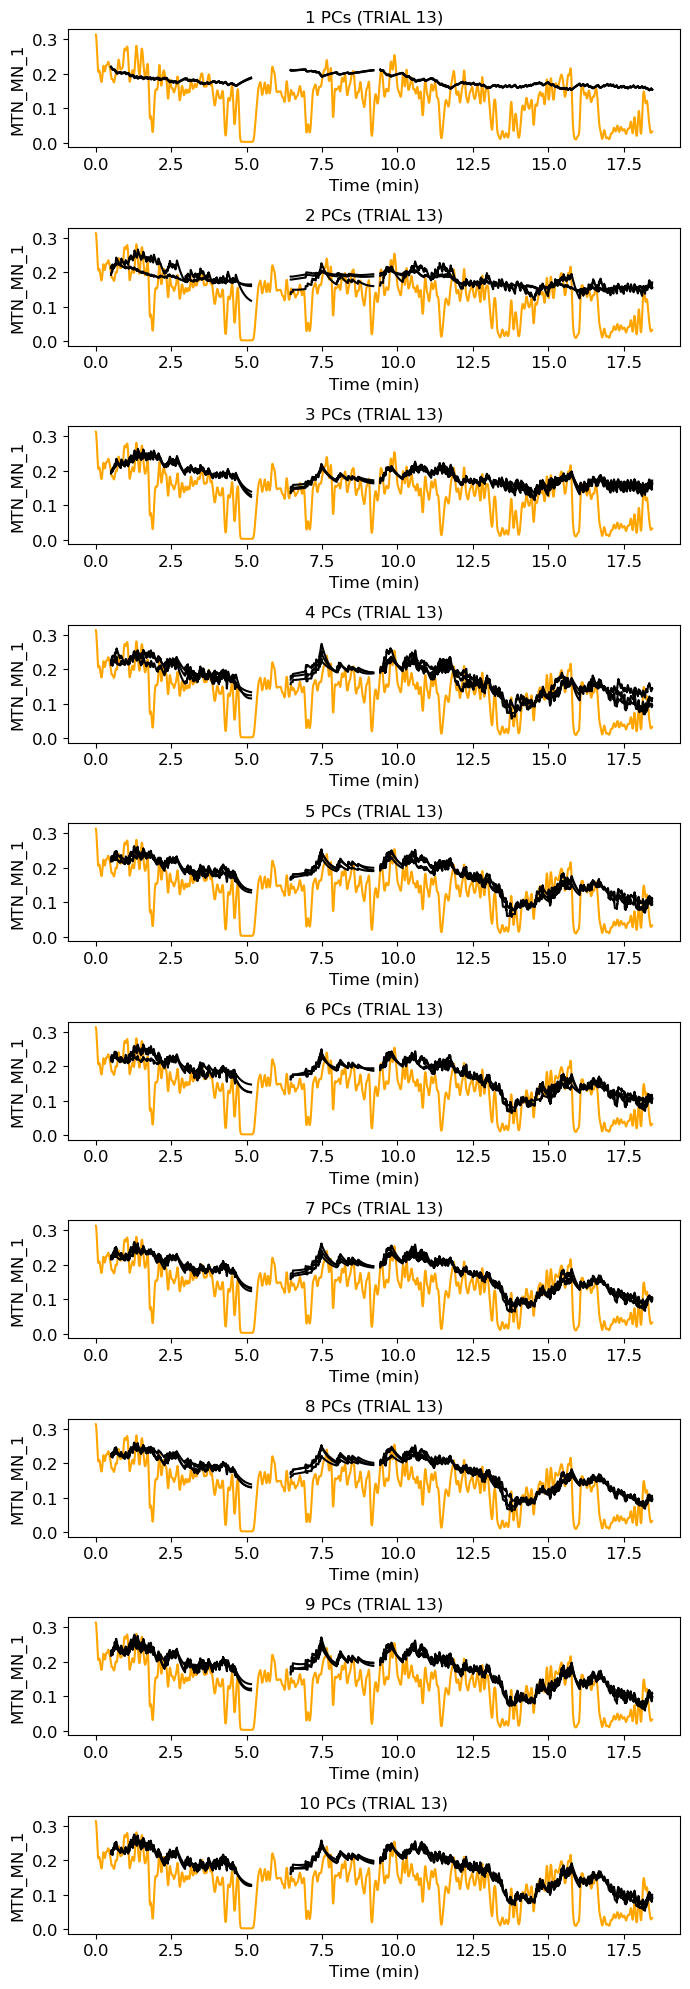

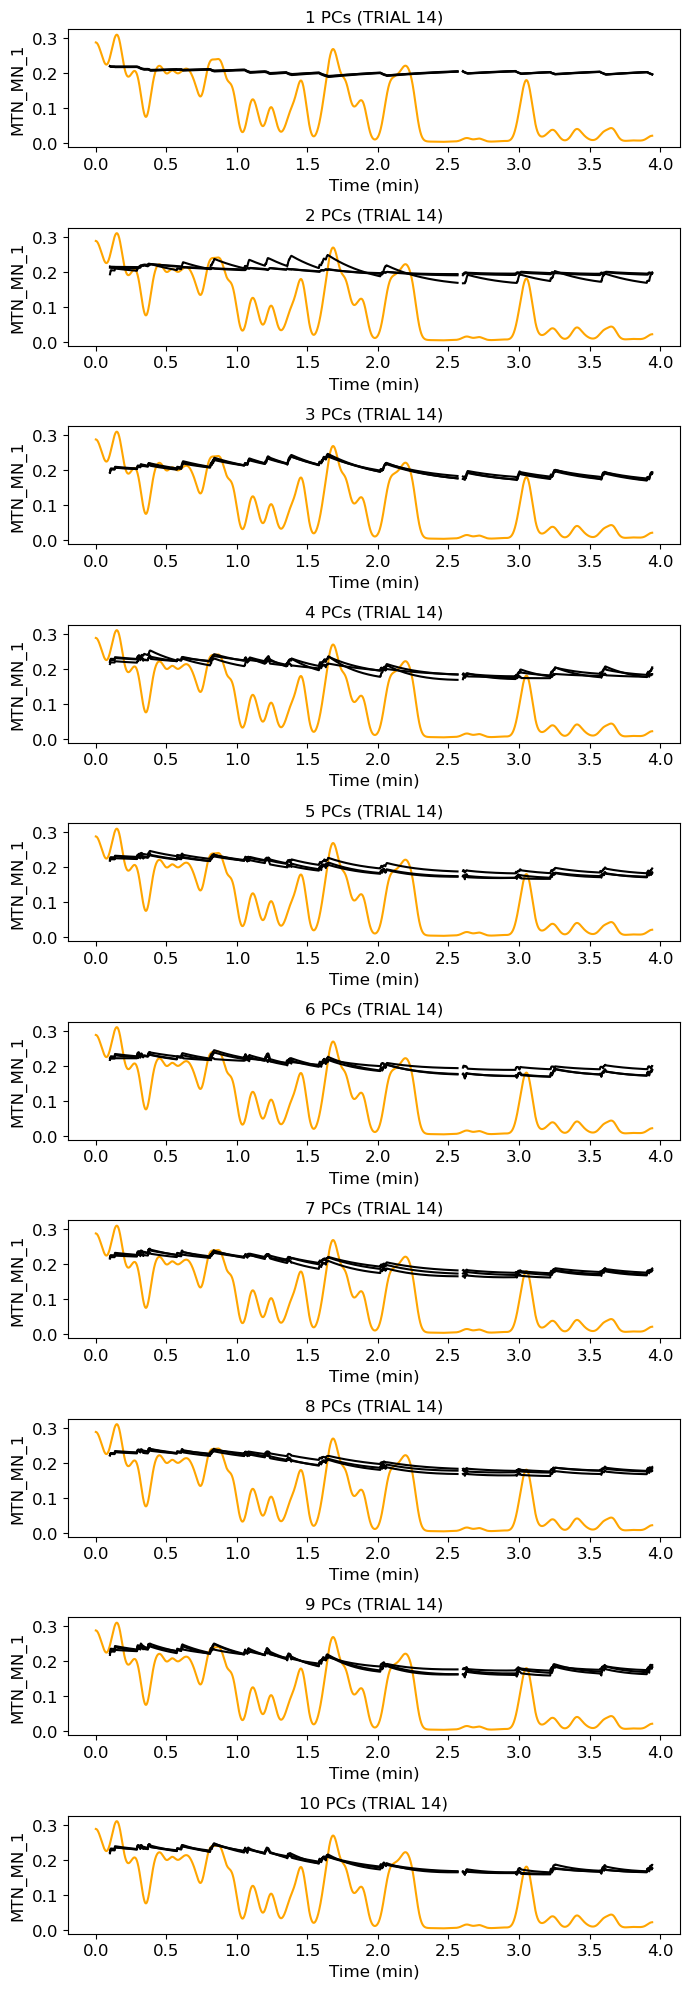

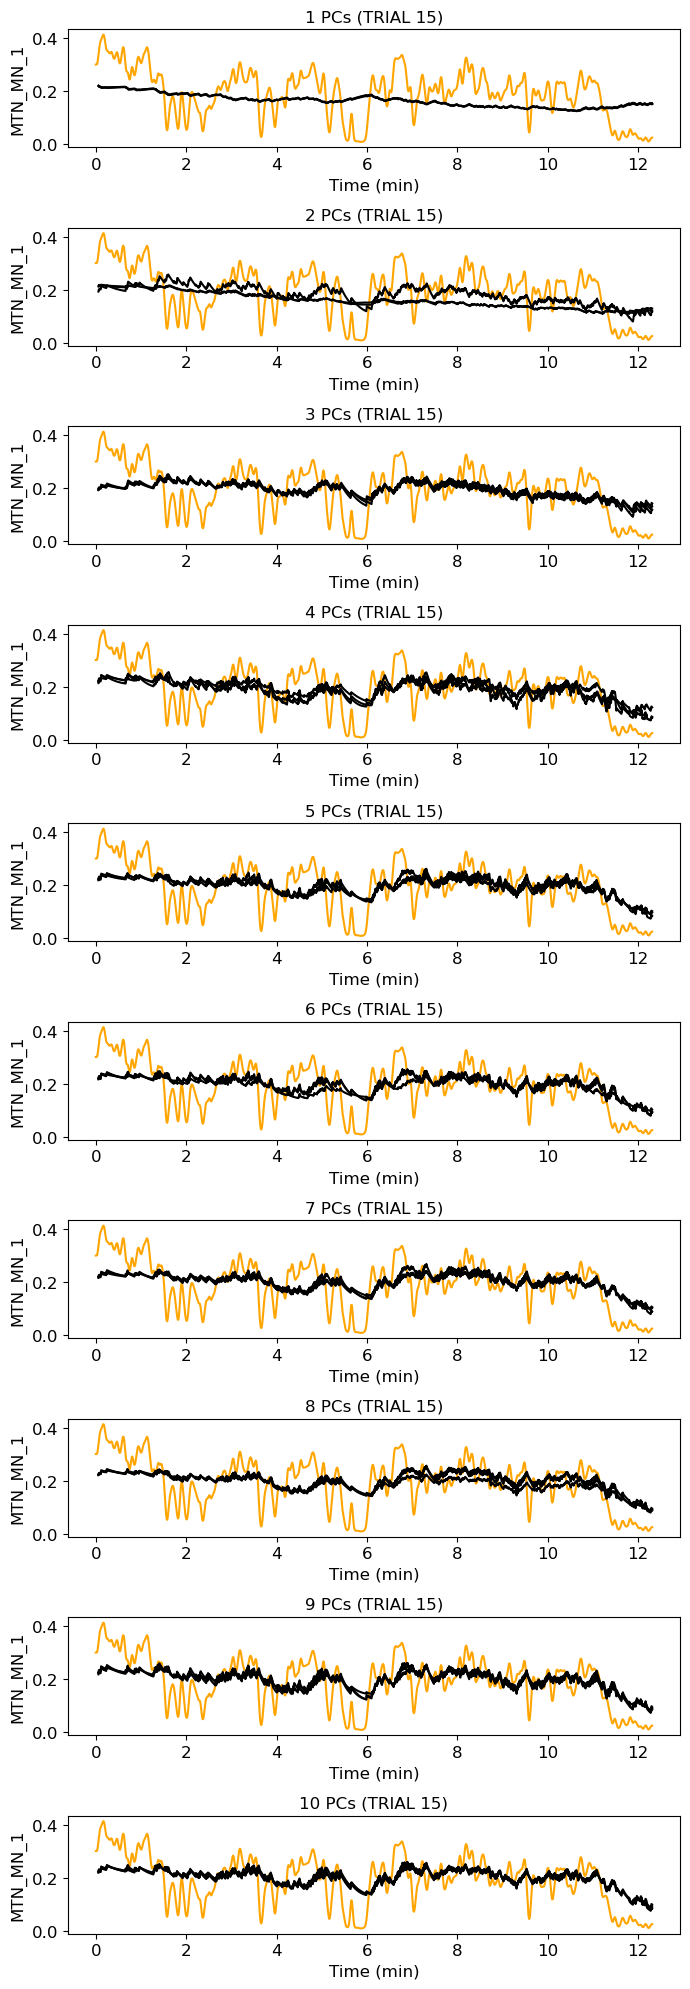

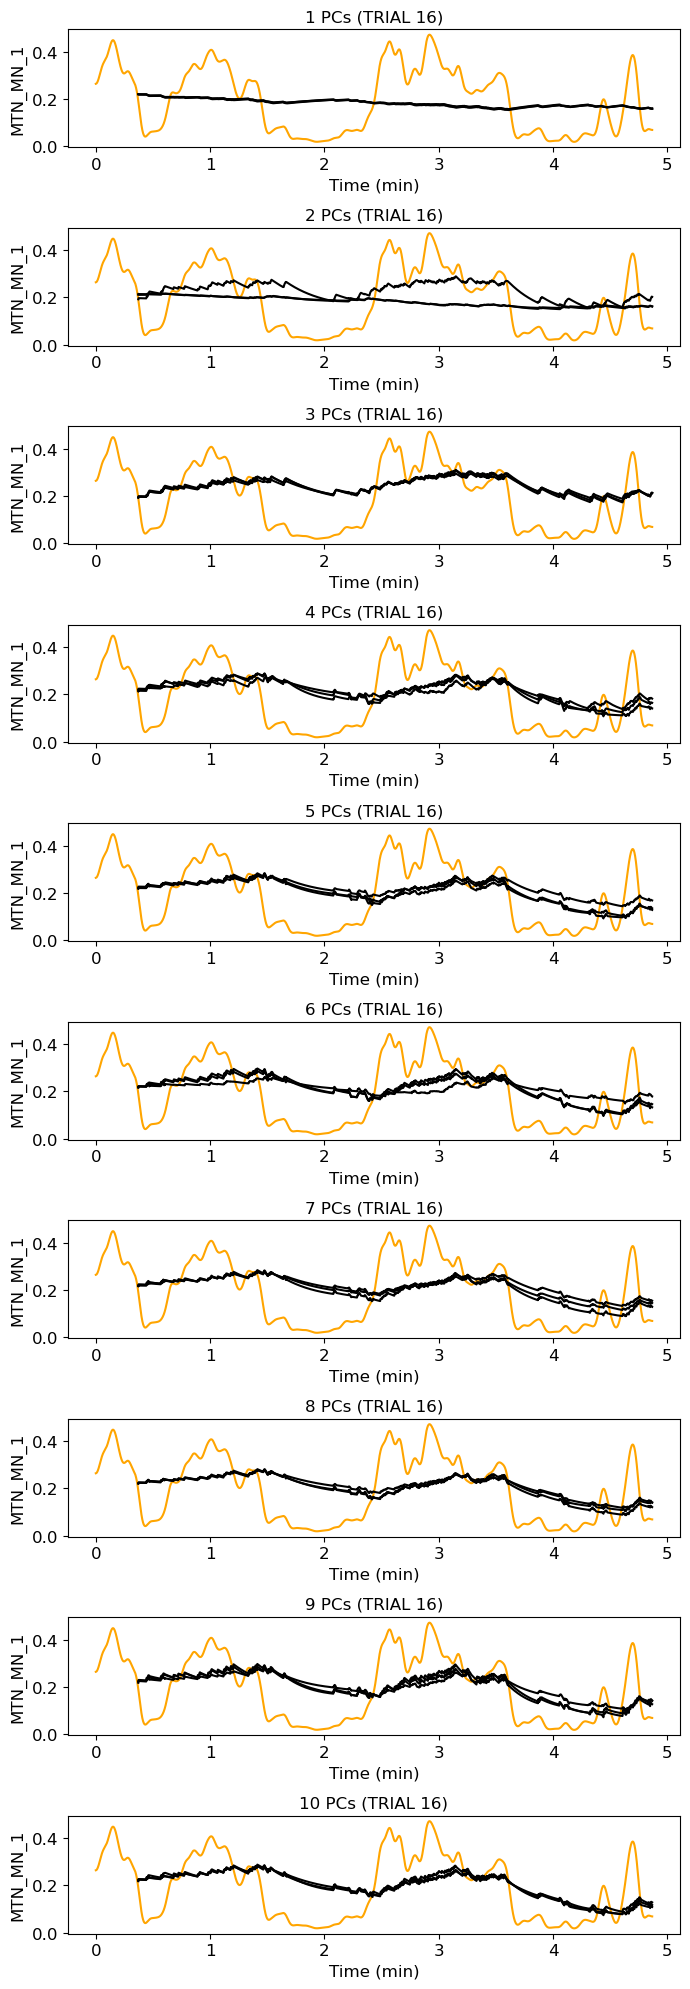

In [10]:
ISPLIT = 0
NTR_SHOW = 17
TARG = TARGS[1]


for ctr in range(NTR_SHOW):
    fig, axs = plt.subplots(len(npcs), 1, figsize=(7, len(npcs)*2), tight_layout=True)

    for cnpc, npc in enumerate(npcs):
        y_test = y_tests[TARG][cnpc][0][ISPLIT][ctr]
        t = np.arange(len(y_test))*DT/60
        axs[cnpc].plot(t, smooth(y_test, 50), c='orange')

        for cppln in range(len(y_tests[TARG][cnpc])):
            try:
                y_hat_test = y_hat_tests[TARG][cnpc][cppln][ISPLIT][ctr]
            except:
                continue
            axs[cnpc].plot(t, y_hat_test, c='k')

        set_plot(axs[cnpc], x_label='Time (min)', y_label=TARG, title=f'{npc} PCs (TRIAL {ctr})')